In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sns.set(context='paper', style='ticks', font='DejaVu Sans', font_scale=1)

### 1. Extracting data for the model.

In [2]:
epochs = 30 # data partition (important for the dataset construction)

In [3]:
df = pd.read_csv('data_/words_translations.csv')
df.shape

(54314, 10)

In [4]:
df = (df.
      pipe(lambda df: df[~df['rating'].isna()]).
      pipe(lambda df: df[df['rating'] >= 0]).
      pipe(lambda df: df.assign(translation_created_at=pd.to_datetime(df['translation_created_at']))).
      pipe(lambda df: df.assign(word_created_at=pd.to_datetime(df['word_created_at']))).
      # create 100 bins (pd.date_rae(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs))
      pipe(lambda df: df.assign(bin=pd.cut(df['translation_created_at'], bins=epochs, labels=range(epochs)))).
      pipe(lambda df: df[~df['bin'].isna()]).
      pipe(lambda df: df.assign(word_n_words=df['word_body'].str.split().str.len())).
      pipe(lambda df: df[df['word_n_words'] == 1]).
      pipe(lambda df: df.assign(translation_n_words=df['translation_body'].str.split().str.len())).
      # only keep translations with 1 word
      pipe(lambda df: df[df['translation_n_words'] == 1]).
      # compute lengths in characters for each translation
      pipe(lambda df: df.assign(translation_len=df['translation_body'].str.len())).
      pipe(lambda df: df.assign(word_len=df['word_body'].str.len())).
      pipe(lambda df: df[df['translation_len'] > 1]).
      pipe(lambda df: df[df['word_len'] > 1])
).dropna()

In [5]:
df['translation_created_at'].max()

Timestamp('2023-06-15 13:25:59.457616')

In [6]:
votes = pd.read_csv("data_/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
# votes['bin'] = pd.cut(votes['created_at'], bins=epochs, labels=range(epochs))
# use datettime from df to create identical bins ('translation_created_at') and label then with range(epochs)
votes['bin'] = pd.cut(votes['created_at'], bins=pd.date_range(start=df['translation_created_at'].min(), 
                                                              end=df['translation_created_at'].max(), 
                                                              periods=epochs+1), labels=range(epochs))
votes = votes[~votes['bin'].isna()]

In [7]:
# votes should have the same translations as df
votes = votes[votes['translation_id'].isin(df['translation_id'])]
print(votes['user_id'].unique().shape[0])
# group by bin and user and count the number of votes
votes_ = votes.groupby(['bin', 'user_id']).size().reset_index(name='votes')
# for each bin, get the list of values in the column 'votes'
votes_ = votes_.query('votes > 0')
votes_ = votes_.groupby('bin')['votes'].apply(list).reset_index(name='votes')

4700


In [8]:
df.shape

(42044, 15)

In [9]:
# table with n of unique words and translations per bin
df_unique = df.groupby('bin').agg({'word_id': 'nunique', 'translation_id': 'nunique'}).reset_index()
df_unique.columns = ['bin', 'n_words', 'n_translations']

In [10]:
votes_ = votes_.set_index('bin')['votes'].to_dict()
n_words = df_unique['n_words'].to_numpy().round().astype(int)
n_translations = df_unique['n_translations'].to_numpy().astype(int)
translation_len = df['translation_len'].to_numpy().astype(int)

In [11]:
with open('data/n_words.pkl', 'wb') as f:
    pickle.dump(n_words, f)

with open('data/n_translations.pkl', 'wb') as f:
    pickle.dump(n_translations, f)

with open('data/votes.pkl', 'wb') as f:
    pickle.dump(votes_, f)

with open('data/translation_len.pkl', 'wb') as f:
    pickle.dump(translation_len, f)

In [12]:
# true_likes = df['rating'].to_numpy()
true_likes = votes.groupby('translation_id').count()['id'].values
true_ranked = np.argsort(true_likes)[::-1]
true_likes = true_likes[true_ranked]

In [13]:
sum(true_likes) == sum([sum(v) for v in votes_.values()])

True

In [14]:
sum(true_likes)

129974

In [15]:
# add zeros so that the length of true_likes is (number of unique translations)
true_likes = np.concatenate([true_likes, np.zeros(df_unique['n_translations'].sum() - len(true_likes))])
true_likes.shape

(42044,)

In [16]:
# dump true_likes
with open('data/true_likes.pkl', 'wb') as f:
    pickle.dump(true_likes, f)

In [20]:
votes_count = np.array([sum(v) for v in votes_.values()])

### 2. Summary figures

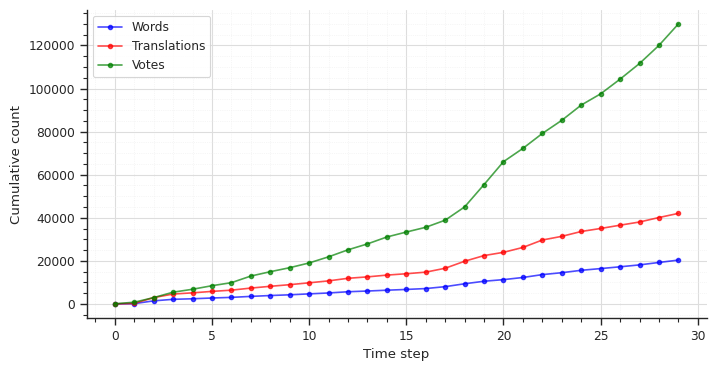

In [21]:
# plot cumulative number of words
fig, ax = plt.subplots(figsize=(8, 4))
# plt.grid(alpha=0.2, linestyle='--')
plt.plot(df_unique['bin'], df_unique['n_words'].cumsum(), 
         label='Words', marker='o', markersize=3, color='blue', alpha=0.7)
plt.plot(df_unique['bin'], df_unique['n_translations'].cumsum(), 
         label='Translations', marker='o', markersize=3, color='red', alpha=0.7)
plt.plot(df_unique['bin'], votes_count.cumsum(), 
         label='Votes',  marker='o', markersize=3, color='green', alpha=0.7)
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Cumulative count')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
plt.savefig('figures/cumulative.pdf', bbox_inches='tight', pad_inches=0)
sns.despine()
plt.show()

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_98995/3491509433.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x / 100) for x in vals])


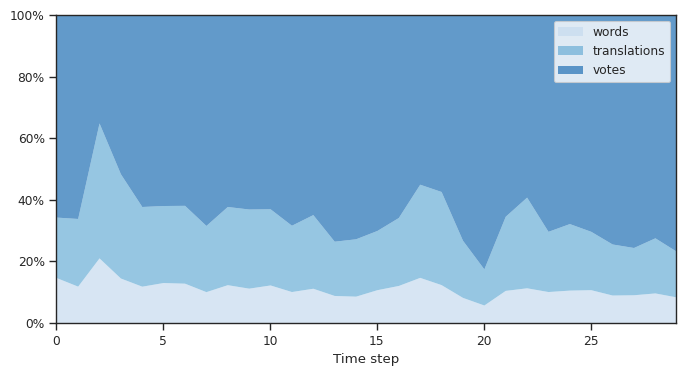

In [22]:
colors = sns.color_palette("Blues", 3)
fig, ax = plt.subplots(figsize=(8, 4))
total_count = df_unique['n_words'] + df_unique['n_translations'] + votes.groupby('bin')['id'].nunique().reindex(df_unique['bin']).fillna(0)
ax.fill_between(df_unique['bin'], 0, df_unique['n_words'] / total_count * 100, label='words', color=colors[0], linewidth=0, alpha=0.7)
ax.fill_between(df_unique['bin'], df_unique['n_words'] / total_count * 100, (df_unique['n_words'] + df_unique['n_translations']) / total_count * 100, 
                label='translations', color=colors[1], linewidth=0, alpha=0.7)
votes_count = votes.groupby('bin')['id'].nunique().reindex(df_unique['bin']).fillna(0)
ax.fill_between(df_unique['bin'], (df_unique['n_words'] + df_unique['n_translations']) / total_count * 100, 
                (df_unique['n_words'] + df_unique['n_translations'] + votes_count) / total_count * 100, label='votes', color=colors[2], linewidth=0, alpha=0.7)
ax.set_ylim(0, 100)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x / 100) for x in vals])
plt.xlabel('Time step')
plt.ylabel('')
plt.legend()
plt.margins(0, 0)
plt.savefig('figures/summary.pdf', bbox_inches='tight', pad_inches=0)
plt.show()